In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customers/extract - fees - data analyst - .csv
/kaggle/input/bank-customers/extract - cash request - data analyst.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


In [3]:
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
fees= pd.read_csv('/kaggle/input/bank-customers/extract - fees - data analyst - .csv')
cash_request= pd.read_csv('/kaggle/input/bank-customers/extract - cash request - data analyst.csv')

In [5]:
# Merge datasets using cash_request_id from fees and id from cash_request
merged_df = fees.merge(cash_request, left_on='cash_request_id', right_on='id', how='inner')

# Drop redundant columns (ensure 'id_y' exists before dropping)
if 'id_y' in merged_df.columns:
    merged_df = merged_df.drop(columns=["id_y"])

# Rename columns for clarity
merged_df.rename(columns={"id_x": "fee_id", "cash_request_id": "cash_request_id"}, inplace=True)

#  Correct Column Naming
if 'created_at_y' in merged_df.columns:  # Prefer cash request date
    merged_df['created_at_cash_request'] = merged_df['created_at_y']
    merged_df = merged_df.drop(columns=["created_at_y"])
    if 'created_at_x' in merged_df.columns:  # Use fee date if cash request date is missing
        merged_df['created_at_fees'] = merged_df['created_at_x']
        merged_df = merged_df.drop(columns=["created_at_x"])
else:
    raise KeyError("Column 'created_at' not found in merged dataset")

#  Convert 'created_at_cash_request' to datetime
merged_df['created_at_cash_request'] = pd.to_datetime(merged_df['created_at_cash_request'], errors='coerce')

#  Create Month Column for Cash Request
merged_df['Month_cash_request'] = merged_df['created_at_cash_request'].dt.to_period('M')
merged_df['Month_cash_request'] = merged_df['Month_cash_request'].astype(str)  # Convert to string
merged_df['Month_cash_request'] = pd.to_datetime(merged_df['Month_cash_request'], format='%Y-%m')

merged_df['Month_Num_cash_request'] = ((merged_df['Month_cash_request'] - merged_df['Month_cash_request'].min()).dt.days // 30)

#  Convert 'created_at_fees' to datetime
merged_df['created_at_fees'] = pd.to_datetime(merged_df['created_at_fees'], errors='coerce')

#  Create Month Column for Fees
merged_df['Month_fees'] = merged_df['created_at_fees'].dt.to_period('M')
merged_df['Month_fees'] = merged_df['Month_fees'].astype(str)  # Convert to string
merged_df['Month_fees'] = pd.to_datetime(merged_df['Month_fees'], format='%Y-%m')

merged_df['Month_Num_fees'] = ((merged_df['Month_fees'] - merged_df['Month_fees'].min()).dt.days // 30)

#  Display the merged dataset info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21057 entries, 0 to 21056
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   fee_id                      21057 non-null  int64              
 1   cash_request_id             21057 non-null  float64            
 2   type                        21057 non-null  object             
 3   status_x                    21057 non-null  object             
 4   category                    2196 non-null   object             
 5   total_amount                21057 non-null  float64            
 6   reason                      21057 non-null  object             
 7   updated_at_x                21057 non-null  object             
 8   paid_at                     15531 non-null  object             
 9   from_date                   7766 non-null   object             
 10  to_date                     7766 non-null   object        

In [6]:
import plotly.express as px 

fig= px.imshow(merged_df.isnull(),
              color_continuous_scale=['gray','green'],
              labels=dict(color='NaN'),
              title='Color Map for the Merged Data Frame(Inner Join)')
fig.update_layout(width=700, height=700)
fig.update_coloraxes(showscale= False)
fig.show()

In [7]:
merged_df.head()

,fee_id,cash_request_id,type,status_x,category,total_amount,reason,updated_at_x,paid_at,from_date,...,send_at,recovery_status,reco_creation,reco_last_update,created_at_cash_request,created_at_fees,Month_cash_request,Month_Num_cash_request,Month_fees,Month_Num_fees
0,6537,14941.0,instant_payment,rejected,NaN,5.0,Instant Payment Cash Request 14941,2020-10-13 14:25:09.396112+00,2020-12-17 14:50:07.47011+00,NaN,...,2020-09-14 10:46:57.735172+00,pending,2020-10-11 22:52:52.274832+00,2020-12-20 22:40:42.556534+00,2020-09-07 10:46:57.780263+00:00,2020-09-07 10:47:27.423150+00:00,2020-09-01,5,2020-09-01,4
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-10-13 14:25:15.537063+00,2020-12-08 17:13:10.45908+00,NaN,...,2020-08-17 13:15:54.290998+00,completed,2020-09-09 20:51:17.992852+00,2020-10-10 22:58:13.306027+00,2020-08-10 13:15:54.291488+00:00,2020-09-09 20:51:17.998653+00:00,2020-08-01,4,2020-09-01,4
2,16296,23371.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352994+00,2020-11-04 19:34:37.43291+00,NaN,...,2020-10-23 10:10:52.894637+00,NaN,NaN,NaN,2020-10-23 10:10:43.278601+00:00,2020-10-23 10:10:58.352972+00:00,2020-10-01,6,2020-10-01,5
3,20775,26772.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643982+00,2020-11-19 05:09:22.500223+00,NaN,...,2020-10-31 15:46:46.846335+00,NaN,NaN,NaN,2020-10-31 15:46:14.156730+00:00,2020-10-31 15:46:53.643958+00:00,2020-10-01,6,2020-10-01,5
4,11242,19350.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 19350,2020-10-13 14:25:03.267983+00,2020-11-02 14:45:20.355598+00,NaN,...,2020-10-13 00:40:23.983346+00,completed,2020-10-24 22:43:13.278707+00,2020-11-02 14:45:20.333109+00,2020-10-06 00:40:24.008752+00:00,2020-10-06 08:20:17.170432+00:00,2020-10-01,6,2020-10-01,5


In [8]:
# Create 3 group based on the spenditures
bins =[cash_request['amount'].min(), 50, 150, cash_request['amount'].max()]
labels=['Low', 'Medium', 'High']
merged_df['spend_segment'] = pd.cut(cash_request['amount'], bins=bins, labels=labels, include_lowest=True)



# Perform cohort analysis for each spending segment
cohort_pivot_spend = merged_df.pivot_table(index=['Month_cash_request', ],
                                                 columns='spend_segment',
                                                 values='user_id',
                                                 aggfunc='nunique')
cohort_pivot_spend

spend_segment,Low,Medium,High
Month_cash_request,,,
2020-04-01,1,0,0
2020-05-01,34,80,0
2020-06-01,251,576,1
2020-07-01,315,736,0
2020-08-01,624,1408,5
2020-09-01,974,2081,7
2020-10-01,2296,4868,10
2020-11-01,44,69,0


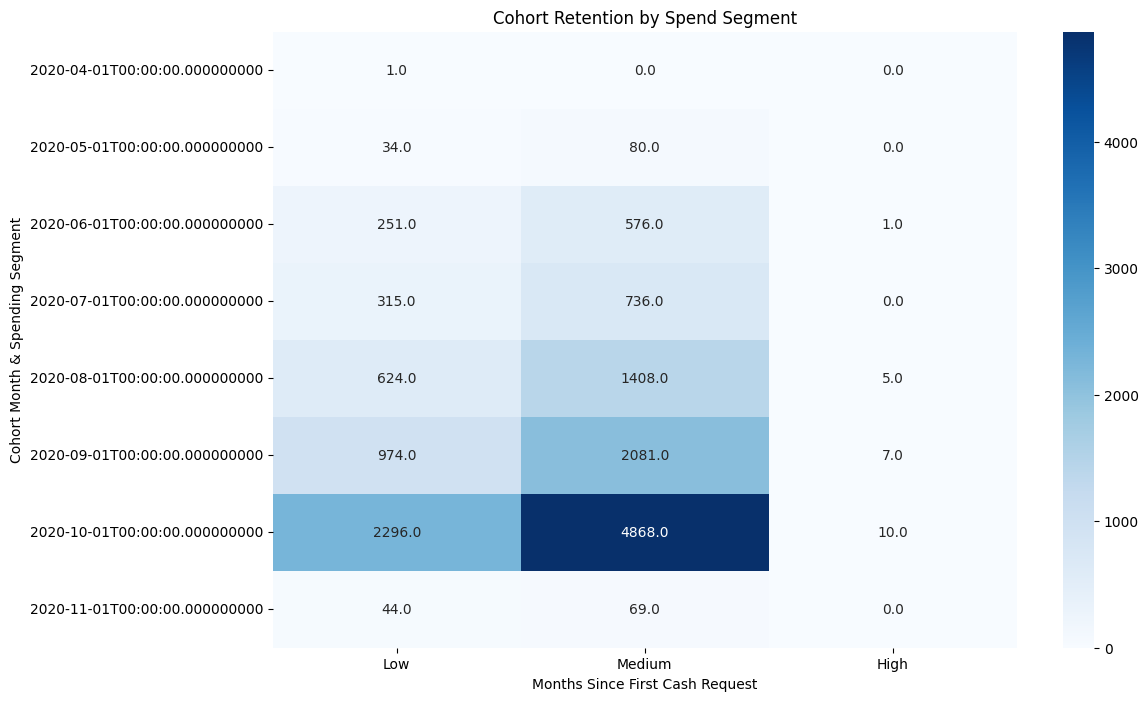

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot_spend, annot=True, fmt=".1f", cmap="Blues")
plt.title("Cohort Retention by Spend Segment")
plt.xlabel("Months Since First Cash Request")
plt.ylabel("Cohort Month & Spending Segment")
plt.show()

In [10]:
# Aggregate user-level data

user_features = merged_df.groupby('user_id').agg(
    num_requests=('user_id', 'count'),  # Total requests per user
    avg_amount=('amount', 'mean'),  # Average amount per request
    total_amount=('amount', 'sum'),  # Total borrowed amount
    first_request_month=('Month_cash_request', 'min'),  # First request date
    last_request_month=('Month_cash_request', 'max'),  # Last request date
    fees_paid=('total_amount', 'sum')  # Total fees paid
).reset_index()

# Convert first request month into categorical time periods
user_features['first_request_month'] = pd.to_datetime(user_features['first_request_month'], errors='coerce')
user_features['last_request_month'] = pd.to_datetime(user_features['last_request_month'], errors='coerce')


# Calculate user activity duration in days
user_features['user_lifetime'] = (user_features['last_request_month'] - user_features['first_request_month']).dt.days

# Convert first request month into categorical time periods (YYYY-MM format)
user_features['first_request_month'] = user_features['first_request_month'].dt.to_period('M')

# Classify users into spending segments
def classify_segment(amount):
    if amount < 100:  # Define thresholds based on data distribution
        return 'Low'
    elif amount < 500:
        return 'Medium'
    else:
        return 'High'

user_features['spend_segment'] = user_features['total_amount'].apply(classify_segment)

# Drop unnecessary columns
user_features = user_features.drop(columns=['last_request_month'])

user_features

,user_id,num_requests,avg_amount,total_amount,first_request_month,fees_paid,user_lifetime,spend_segment
0,47.0,10,8.1,81.0,2020-05,50.0,153,Low
1,52.0,2,15.0,30.0,2020-08,10.0,31,Low
2,53.0,1,100.0,100.0,2020-10,5.0,0,Medium
3,72.0,5,56.0,280.0,2020-07,25.0,62,Medium
4,73.0,2,100.0,200.0,2020-09,10.0,30,Medium
...,...,...,...,...,...,...,...,...
8867,103421.0,1,50.0,50.0,2020-11,5.0,0,Low
8868,103425.0,1,100.0,100.0,2020-11,5.0,0,Medium
8869,103437.0,1,100.0,100.0,2020-11,5.0,0,Medium
8870,103496.0,1,100.0,100.0,2020-11,5.0,0,Medium


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set The Random Seed
random_seed=42

# Seprate the Features and the Target coulmns
target=user_features['spend_segment']
features=user_features.drop(columns=['user_id','spend_segment', 'first_request_month'])

# Convert datetime to numeric months


# Encode the spend_segment by LbabelEncoder
label_encoder=LabelEncoder()
target=label_encoder.fit_transform(target)

# Scale The Features With StandardScaler 
standard_scaler= StandardScaler()
features= standard_scaler.fit_transform(features)

# Split Data for Interpolationa, Extrapolation, Train and Test
X_interap, X_extrap, y_interap, y_extrap= train_test_split(features, target, test_size=0.3, random_state= random_seed, shuffle=False)
# X_train, X_test, Y_train, Y_test = train_test_split(X_interap, y_interap, test_size=0.2, random_state=random_seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_interap, y_interap, test_size=0.3, random_state=random_seed, shuffle=True)

# Create a SVM Model With RBF Kernel
svm_model= SVC(kernel='rbf', C=1, gamma=0.1, probability=True)

# Perform 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
cv_scores = cross_val_score(svm_model, features, target, cv=kf, scoring='accuracy')

# Display cross-validation results
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))
print("Standard Deviation of Accuracy:", np.std(cv_scores))


svm_model.fit(X_train, y_train)

Cross-Validation Scores: [0.98873239 0.98816901 0.98816234 0.99492672 0.99154453]
Mean Accuracy: 0.9903070009686076
Standard Deviation of Accuracy: 0.002627668312590126


SVC(C=1, gamma=0.1, probability=True)

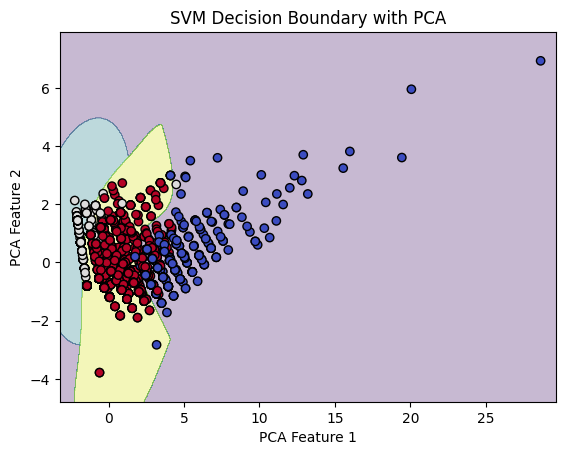

In [12]:
from sklearn.decomposition import PCA
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
svm_pca_model = SVC(kernel='rbf', C=1, gamma=0.1, probability=True)
svm_pca_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

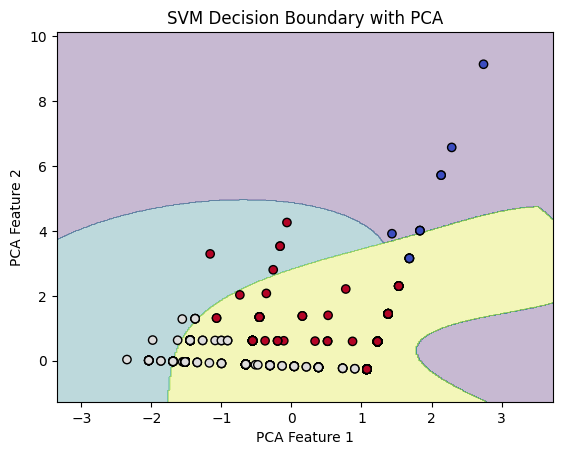

In [13]:
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data 

# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min, y_max = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer


# Classification Report For The Test Data 
y_pred_test = svm_model.predict(X_test)

# Print accuracy
from sklearn.metrics import accuracy_score, classification_report
print('-'*50,'\n','Test')
print("SVM Model Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Confusion Matrix 
cm_svm= confusion_matrix(y_test, y_pred_test)
print(cm_svm)

y_pred_extrap = svm_model.predict(X_extrap)

print('-'*50,'\n','Extrapolation')
print("SVM Model Accuracy:", accuracy_score(y_extrap, y_pred_extrap))
print("Classification Report:\n", classification_report(y_extrap, y_pred_extrap))
cm_svm_extrap= confusion_matrix(y_extrap, y_pred_extrap)
print(cm_svm_extrap)

-------------------------------------------------- 
 Test
SVM Model Accuracy: 0.9871175523349437
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       182
           1       1.00      0.94      0.97       363
           2       0.98      1.00      0.99      1318

    accuracy                           0.99      1863
   macro avg       0.99      0.98      0.98      1863
weighted avg       0.99      0.99      0.99      1863

[[ 181    0    1]
 [   0  343   20]
 [   3    0 1315]]
-------------------------------------------------- 
 Extrapolation
SVM Model Accuracy: 0.9868519909842224
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.97      0.99      1300
           2       0.97      1.00      0.99      1349

    accuracy                           0.99      2662
   macro avg       0.99      0.99      0.

In [15]:
from sklearn.preprocessing import LabelBinarizer
# AUC for each class 
lb_svm= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= svm_model.predict_proba(X_test)

y_extrap_bin= lb_svm.fit_transform(y_extrap)
y_pred_prob_extrap= svm_model.predict_proba(X_extrap)


# Calculate the AUC for each class 
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test 
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test 
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

--------------------------------------------------
Interpolation
AUC pf the class0: 0.9999411653189166
AUC pf the class1: 0.9999889807162534
AUC pf the class2: 0.9999136862914341
--------------------------------------------------
Extrapolation
AUC pf the class0: 0.9999136862914341
AUC pf the class1: 0.9999136862914341
AUC pf the class2: 0.9999136862914341


In [16]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Kernel types
}

# Create SVM model
svm_model = SVC(probability=True)
# Define K-Fold Cross-Validation strategy (Stratified ensures class balance)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Implement GridSearchCV with K-Fold CV
grid_search = GridSearchCV(svm_model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1, verbose=3)


# Fit on training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on test data
test_accuracy = best_svm_model.score(X_test, y_test)
print("Test Accuracy of Best Model:", test_accuracy)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Hyperparameters: {'C': 100, 'gamma': 0.01, 'kernel': 'linear'}
Test Accuracy of Best Model: 0.9989264626945786


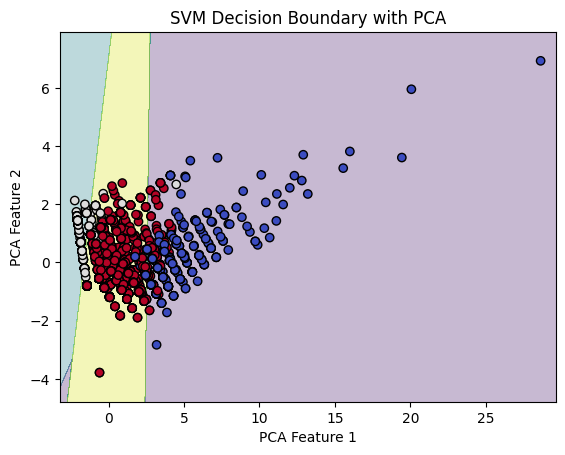

In [17]:
from sklearn.decomposition import PCA
# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
svm_pca_best_model = SVC(kernel='linear', C=100, gamma=0.01, probability=True)
svm_pca_best_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

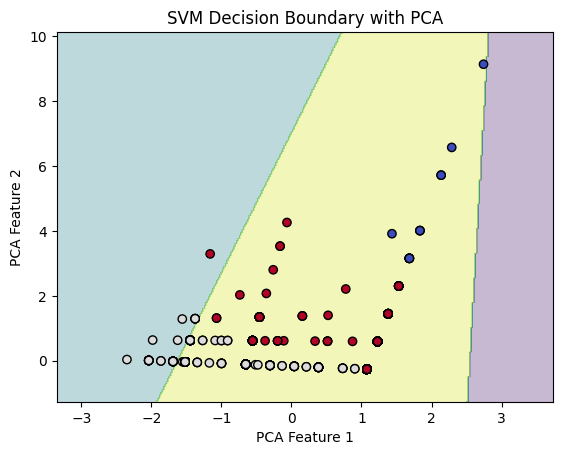

In [18]:
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data


# Visualize the descision area
# Define mesh step size
h_svm = 0.02  

# Extract PCA feature limits
x_min, x_max = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min, y_max = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h_svm),
    np.arange(y_min, y_max, h_svm)
)

# Predict on mesh grid using SVM trained on PCA data
Z = svm_pca_best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("SVM Decision Boundary with PCA")
plt.show()

In [19]:
# AUC for each class 
lb_svm= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= best_svm_model.predict_proba(X_test)

y_extrap_bin= lb_svm.fit_transform(y_extrap)
y_pred_prob_extrap= best_svm_model.predict_proba(X_extrap)


# Calculate the AUC for each class 
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test 
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test 
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

--------------------------------------------------
Interpolation
AUC pf the class0: 0.9999280909453425
AUC pf the class1: 1.0
AUC pf the class2: 0.9999373529534603
--------------------------------------------------
Extrapolation
AUC pf the class0: 0.9999373529534603
AUC pf the class1: 0.9999373529534603
AUC pf the class2: 0.9999373529534603


#### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Set up the KNN model with n_neighbors= 10 
n_neighbors= 10
knn_model = KNeighborsClassifier(n_neighbors = n_neighbors)
knn_model.fit(X_train, y_train)



KNeighborsClassifier(n_neighbors=10)

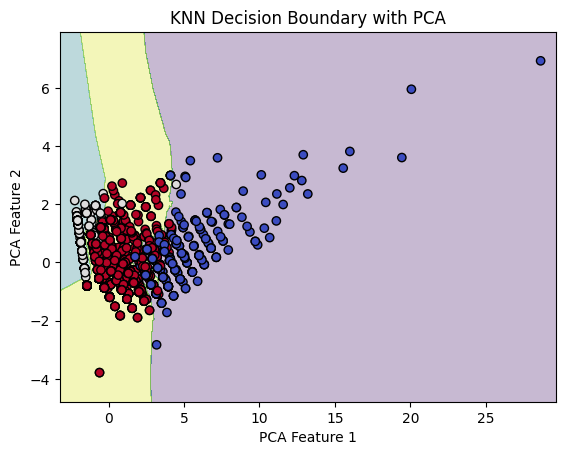

In [21]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Transform training data
X_test_pca = pca.transform(X_test)

# Train SVM on PCA-reduced data
knn_pca_model = KNeighborsClassifier(n_neighbors = n_neighbors)
knn_pca_model.fit(X_train_pca, y_train)

# Visualize the descision area
# Define mesh step size
h_knn = 0.02  

# Extract PCA feature limits
x_min_knn, x_max_knn = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min_knn, y_max_knn = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min_knn, x_max_knn, h_knn),
    np.arange(y_min_knn, y_max_knn, h_knn)
)

# Predict on mesh grid using SVM trained on PCA data
Z = knn_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("KNN Decision Boundary with PCA")
plt.show()

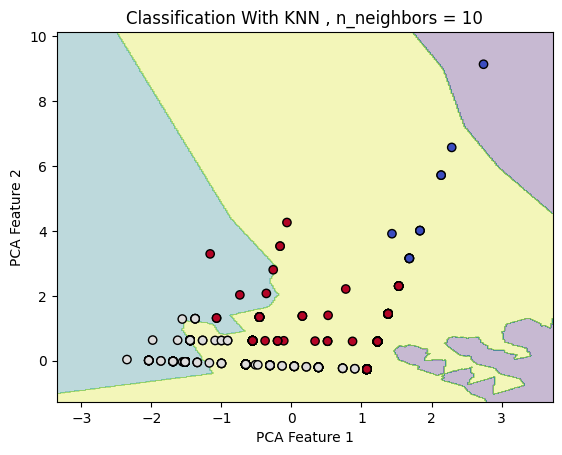

In [22]:
pca = PCA(n_components=2)
X_extrap_pca = pca.fit_transform(X_extrap)  # Transform training data
X_extrap_pca = pca.transform(X_extrap)


# Visualize the descision area
# Define mesh step size
h_knn = 0.02  

# Extract PCA feature limits
x_min_knn, x_max_knn = X_extrap_pca[:, 0].min() - 1, X_extrap_pca[:, 0].max() + 1
y_min_knn, y_max_knn = X_extrap_pca[:, 1].min() - 1, X_extrap_pca[:, 1].max() + 1

# Generate grid points
xx, yy = np.meshgrid(
    np.arange(x_min_knn, x_max_knn, h_knn),
    np.arange(y_min_knn, y_max_knn, h_knn)
)

# Predict on mesh grid using SVM trained on PCA data
Z = knn_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.3, camp='viridis')
plt.scatter(X_extrap_pca[:, 0], X_extrap_pca[:, 1], c=y_extrap, edgecolors='k', cmap=plt.cm.coolwarm)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.title("Classification With KNN , n_neighbors = 10")
plt.show()

In [23]:
y_pred_test_knn = knn_model.predict(X_test)
y_pred_extrap_knn= knn_model.predict(X_extrap)

print('Classification Report:')
print(classification_report(y_test, y_pred_test_knn))
print(classification_report(y_extrap, y_pred_extrap_knn))

cm_matrix_test = confusion_matrix(y_test,y_pred_test_knn)
print('Confusion Matrix for the test data:')
print(cm_matrix_test)

cm_matrix_extrap = confusion_matrix(y_extrap,y_pred_extrap_knn)
print('Confusion Matrix for the extrapolation data:')
print(cm_matrix_extrap)

# AUC for each class 
lb_knn= LabelBinarizer()
y_test_bin= lb_svm.fit_transform(y_test)
y_pred_prob_test= knn_model.predict_proba(X_test)

y_extrap_bin= lb_knn.fit_transform(y_extrap)
y_pred_prob_extrap= knn_model.predict_proba(X_extrap)


# Calculate the AUC for each class 
auc_scores_test=[]

for i in range(y_test_bin.shape[-1]):
    auc_test= roc_auc_score(y_test_bin[:,i], y_pred_prob_test[:,i])
    auc_scores_test.append(auc_test)

auc_scores_extrap=[]

for i in range(y_extrap_bin.shape[1]):
    auc_extrapt= roc_auc_score(y_extrap_bin[:,i], y_pred_prob_extrap[:,i])
    auc_scores_extrap.append(auc_test)

# Print the AUC for Each Class in The Test 
print('-'*50)
print('Interpolation')
for i , auc_test in enumerate(auc_scores_test):
    print(f"AUC pf the class{i}: {auc_test}")
print('-'*50)
print('Extrapolation')
# Print the AUC for Each Class in The Test 
for i , auc_extrap in enumerate(auc_scores_extrap):
    print(f"AUC pf the class{i}: {auc_extrap}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       182
           1       1.00      0.98      0.99       363
           2       0.99      0.99      0.99      1318

    accuracy                           0.99      1863
   macro avg       0.98      0.99      0.99      1863
weighted avg       0.99      0.99      0.99      1863

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00      1300
           2       1.00      1.00      1.00      1349

    accuracy                           1.00      2662
   macro avg       1.00      1.00      1.00      2662
weighted avg       1.00      1.00      1.00      2662

Confusion Matrix for the test data:
[[ 181    0    1]
 [   0  356    7]
 [   8    1 1309]]
Confusion Matrix for the extrapolation data:
[[  13    0    0]
 [   0 1296    4]
 [   0    1 1348]]
------------------------

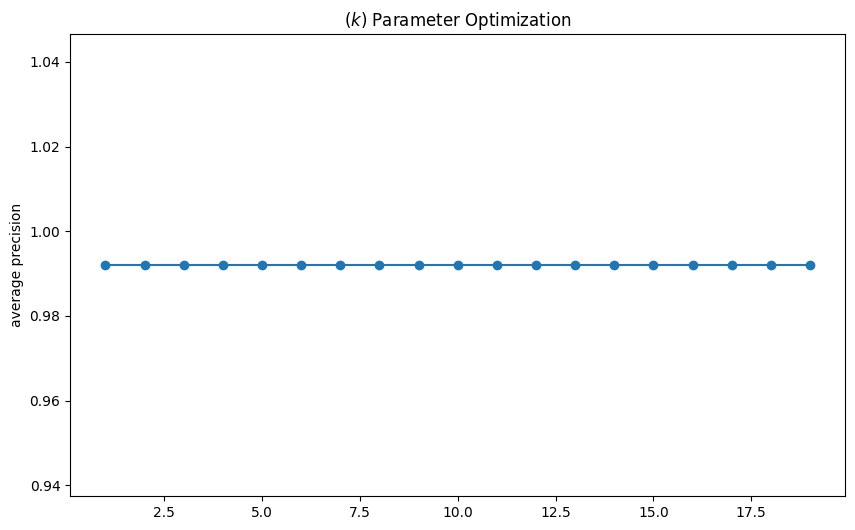

In [24]:
k_values_knn = range(1, 20)
accuracies_knn = []

for k_knn in k_values_knn :
    Knn_model = KNeighborsClassifier(n_neighbors = k_knn)
    scores_knn= cross_val_score(knn_model, X_train , y_train,cv=5)
    accuracies_knn.append(scores_knn.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values_knn, accuracies_knn, marker='o')
plt.title('($k$) Parameter Optimization')
plt.ylabel('average precision')
plt.show()